In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# Load the dataset
file_path = '../data/data_reduced_train.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Define the target variable
target = "% Adults with Diabetes"

# Split the dataset into train, validation, and test subsets
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
validation_relative_size = 0.2 / (1 - 0.2)
train_data, val_data = train_test_split(train_val_data, test_size=validation_relative_size, random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 1884, Validation size: 629, Test size: 629


In [4]:
data.columns

Index(['FIPS', 'State', 'County', '% Adults with Diabetes',
       '% Completed High School', '% Non-Hispanic White',
       'Food Environment Index', 'Median Household Income',
       '% Excessive Drinking', '% Households with Broadband Access',
       '% with Annual Mammogram', '% Census Participation', '% Vaccinated',
       '% Homeowners', '% With Access to Exercise Opportunities',
       '% Severe Housing Problems', 'Average Daily PM2.5', '% Unemployed',
       '% Uninsured', 'Income Ratio', '% Black',
       '% Adults Reporting Currently Smoking', '% Frequent Mental Distress',
       '% Adults with Obesity', '% Children in Single-Parent Households',
       '% Insufficient Sleep', '% Food Insecure', '% Children in Poverty',
       '% Frequent Physical Distress', '% Physically Inactive'],
      dtype='object')

In [5]:
data.describe().round(1)

,FIPS,% Adults with Diabetes,% Completed High School,% Non-Hispanic White,Food Environment Index,Median Household Income,% Excessive Drinking,% Households with Broadband Access,% with Annual Mammogram,% Census Participation,...,% Black,% Adults Reporting Currently Smoking,% Frequent Mental Distress,% Adults with Obesity,% Children in Single-Parent Households,% Insufficient Sleep,% Food Insecure,% Children in Poverty,% Frequent Physical Distress,% Physically Inactive
count,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,...,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0,3142.0
mean,30379.5,10.6,88.4,74.8,7.5,63267.7,16.9,82.4,41.6,58.1,...,9.0,19.0,17.1,37.4,23.9,34.5,11.5,19.4,12.0,26.7
std,15168.6,2.3,5.7,20.3,1.2,16275.5,2.6,7.2,8.2,12.2,...,14.1,4.1,2.1,4.6,10.3,3.6,3.6,8.4,2.2,5.2
min,1001.0,5.6,33.3,2.7,0.0,28972.0,9.0,36.0,6.0,1.2,...,0.0,7.0,11.0,17.4,0.0,23.8,2.2,2.4,6.6,12.0
25%,18177.5,8.9,85.3,63.0,6.9,52471.8,15.0,78.7,36.0,50.2,...,0.8,16.4,15.7,35.1,17.1,31.9,8.9,13.4,10.4,23.1
50%,29176.0,10.2,89.6,82.0,7.7,60820.5,16.9,83.5,42.0,59.5,...,2.3,18.7,17.1,37.7,22.2,34.5,11.2,18.1,11.9,26.3
75%,45080.5,11.8,92.5,91.3,8.3,70586.5,18.5,87.4,47.0,67.4,...,10.1,21.5,18.5,40.3,28.7,36.8,13.8,24.1,13.5,30.1
max,56045.0,22.2,99.7,97.6,10.0,167605.0,26.8,100.0,77.0,92.3,...,85.1,43.0,24.7,52.5,78.5,48.4,26.3,88.7,23.3,47.0


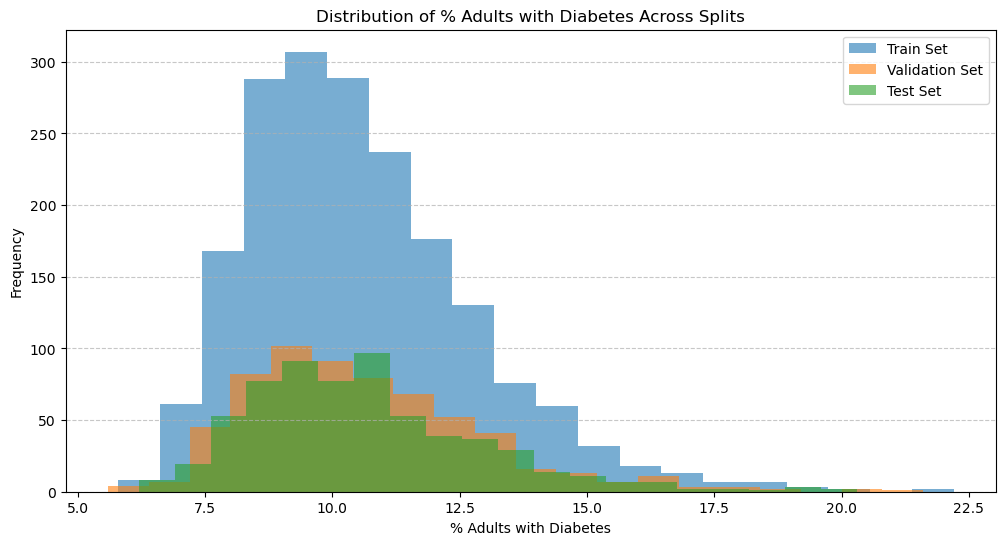

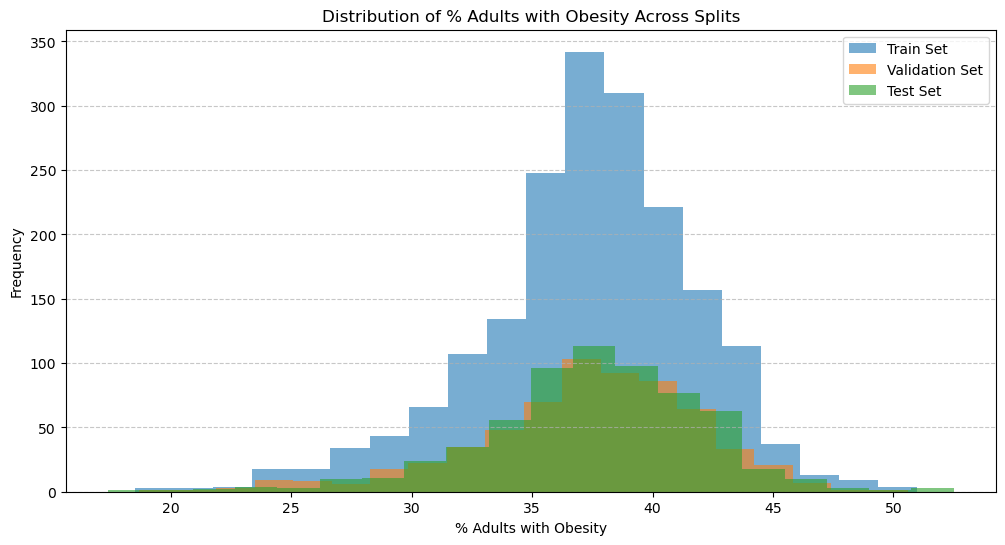

In [6]:
# Plot histograms for % Adults with Diabetes and % Adults with Obesity
columns_to_plot = ["% Adults with Diabetes", "% Adults with Obesity"]
titles = [
    "Distribution of % Adults with Diabetes Across Splits",
    "Distribution of % Adults with Obesity Across Splits"
]

for column, title in zip(columns_to_plot, titles):
    plt.figure(figsize=(12, 6))
    for split_name, split_data in {"Train": train_data, "Validation": val_data, "Test": test_data}.items():
        plt.hist(split_data[column], bins=20, alpha=0.6, label=f"{split_name} Set")
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [7]:
# Define feature groups
health_features = [
    "Deaths", "Years of potential life lost rate", "% Fair or Poor Health",
    "Average Number of Physically Unhealthy Days", "Average Number of Mentally Unhealthy Days",
    "% Low Birthweight", "% Adults with Obesity", "Life Expectancy", "Age-Adjusted Death Rate",
    "Child Mortality Rate", "Infant Mortality Rate", "% Frequent Physical Distress",
    "% Frequent Mental Distress", "HIV Prevalence Rate", 
]

policy_features = [
    "% With Access to Exercise Opportunities", "% Driving Deaths with Alcohol Involvement",
    "Chlamydia Rate", "Teen Birth Rate", "% Uninsured", "Primary Care Physicians Rate",
    "Dentist Rate", "Mental Health Provider Rate", "Preventable Hospitalization Rate",
    "% with Annual Mammogram", "% Vaccinated", "Average Daily PM2.5", "Presence of Water Violation",
    "% Severe Housing Problems", '% Food Insecure', '% Unemployed', '% Completed High School'
]

demographic_features = [
    "Traffic Volume", "% Homeowners", "% Households with Severe Cost Burden",
    "% Households with Broadband Access", "Population", "% Less than 18 Years of Age",
    "% 65 and Over", "% Black", "% American Indian or Alaska Native", "% Asian",
    "% Native Hawaiian or Other Pacific Islander", "% Hispanic", "%Non-Hispanic White",
    "%Not Proficient in English", "% Female", "%Rural", '% Children in Single-Parent Households', 
    'Income Ratio', 'Median Household Income', 'Food Environment Index', '% Children in Poverty', 
    '% Census Participation', '% Non-Hispanic White'
]

lifestyle_features = ['% Physically Inactive', '% Excessive Drinking', 
                      '% Insufficient Sleep', '% Adults Reporting Currently Smoking']


In [8]:
# Filter out non-numeric features
numeric_train_data = train_data.select_dtypes(include=[np.number])
numeric_val_data = val_data.select_dtypes(include=[np.number])

all_features = [col for col in numeric_train_data.columns if col != target]
health_features_filtered = [f for f in health_features if f in numeric_train_data.columns]
policy_features_filtered = [f for f in policy_features if f in numeric_train_data.columns]
demographic_features_filtered = [f for f in demographic_features if f in numeric_train_data.columns]
lifestyle_features_filtered = [f for f in lifestyle_features if f in numeric_train_data.columns]


In [9]:
# Dictionary to store RMSEs
results = {}
models = {}
# Perform cross-validation for each feature set
for feature_set_name, feature_set in {
    "Model 1 (All Features)": all_features,
    "Model 2 (Health Features)": health_features_filtered,
    "Model 3 (Policy Features)": policy_features_filtered,
    "Model 4 (Demographic Features)": demographic_features_filtered,
    "Model 5 (Lifestyle Features)": lifestyle_features_filtered
}.items():
    fold_rmse = []

    # Cross-validation
    for train_index, val_index in kf.split(numeric_train_data):
        # Split into train and validation sets for this fold
        train_fold = numeric_train_data.iloc[train_index]
        val_fold = numeric_train_data.iloc[val_index]

        X_train_fold = train_fold[feature_set]
        y_train_fold = train_fold[target]
        X_val_fold = val_fold[feature_set]
        y_val_fold = val_fold[target]

        # Train the model
        model = XGBRegressor(random_state=42, n_estimators=100, max_depth=5)
        model.fit(X_train_fold, y_train_fold)
        models[feature_set_name] = model

        # Predict and calculate RMSE for the validation fold
        y_pred_fold = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        fold_rmse.append(rmse.round(2))

    # Calculate validation RMSE
    X_val = numeric_val_data[feature_set]
    y_val = numeric_val_data[target]
    y_pred_val = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

    # Calculate test RMSE
    X_test = test_data[feature_set]
    y_test = test_data[target]
    y_pred_test = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Store results
    results[feature_set_name] = {
        "Cross-Validation RMSEs": fold_rmse,
        "Validation RMSE": val_rmse,
        "Test RMSE": test_rmse
    }

# Display the results
for model_name, rmses in results.items():
    print(f"Results for {model_name}:")
    print(f"  Cross-Validation RMSEs: {rmses['Cross-Validation RMSEs']}")
    print(f"  Validation RMSE: {rmses['Validation RMSE']:.2f}")
    print(f"  Test RMSE: {rmses['Test RMSE']:.2f}\n")

Results for Model 1 (All Features):
  Cross-Validation RMSEs: [np.float64(0.45), np.float64(0.51), np.float64(0.53), np.float64(0.47), np.float64(0.45)]
  Validation RMSE: 0.46
  Test RMSE: 0.44

Results for Model 2 (Health Features):
  Cross-Validation RMSEs: [np.float64(1.0), np.float64(1.08), np.float64(1.0), np.float64(0.98), np.float64(0.98)]
  Validation RMSE: 1.07
  Test RMSE: 1.06

Results for Model 3 (Policy Features):
  Cross-Validation RMSEs: [np.float64(1.14), np.float64(1.19), np.float64(1.05), np.float64(1.11), np.float64(1.07)]
  Validation RMSE: 1.10
  Test RMSE: 1.13

Results for Model 4 (Demographic Features):
  Cross-Validation RMSEs: [np.float64(0.9), np.float64(0.97), np.float64(0.94), np.float64(0.94), np.float64(0.92)]
  Validation RMSE: 0.94
  Test RMSE: 0.91

Results for Model 5 (Lifestyle Features):
  Cross-Validation RMSEs: [np.float64(1.0), np.float64(1.04), np.float64(1.04), np.float64(1.01), np.float64(0.9)]
  Validation RMSE: 1.03
  Test RMSE: 0.97



In [10]:
print(health_features_filtered, policy_features_filtered, demographic_features_filtered, lifestyle_features_filtered)

['% Adults with Obesity', '% Frequent Physical Distress', '% Frequent Mental Distress'] ['% With Access to Exercise Opportunities', '% Uninsured', '% with Annual Mammogram', '% Vaccinated', 'Average Daily PM2.5', '% Severe Housing Problems', '% Food Insecure', '% Unemployed', '% Completed High School'] ['% Homeowners', '% Households with Broadband Access', '% Black', '% Children in Single-Parent Households', 'Income Ratio', 'Median Household Income', 'Food Environment Index', '% Children in Poverty', '% Census Participation', '% Non-Hispanic White'] ['% Physically Inactive', '% Excessive Drinking', '% Insufficient Sleep', '% Adults Reporting Currently Smoking']


In [11]:
print(all_features)

['FIPS', '% Completed High School', '% Non-Hispanic White', 'Food Environment Index', 'Median Household Income', '% Excessive Drinking', '% Households with Broadband Access', '% with Annual Mammogram', '% Census Participation', '% Vaccinated', '% Homeowners', '% With Access to Exercise Opportunities', '% Severe Housing Problems', 'Average Daily PM2.5', '% Unemployed', '% Uninsured', 'Income Ratio', '% Black', '% Adults Reporting Currently Smoking', '% Frequent Mental Distress', '% Adults with Obesity', '% Children in Single-Parent Households', '% Insufficient Sleep', '% Food Insecure', '% Children in Poverty', '% Frequent Physical Distress', '% Physically Inactive']


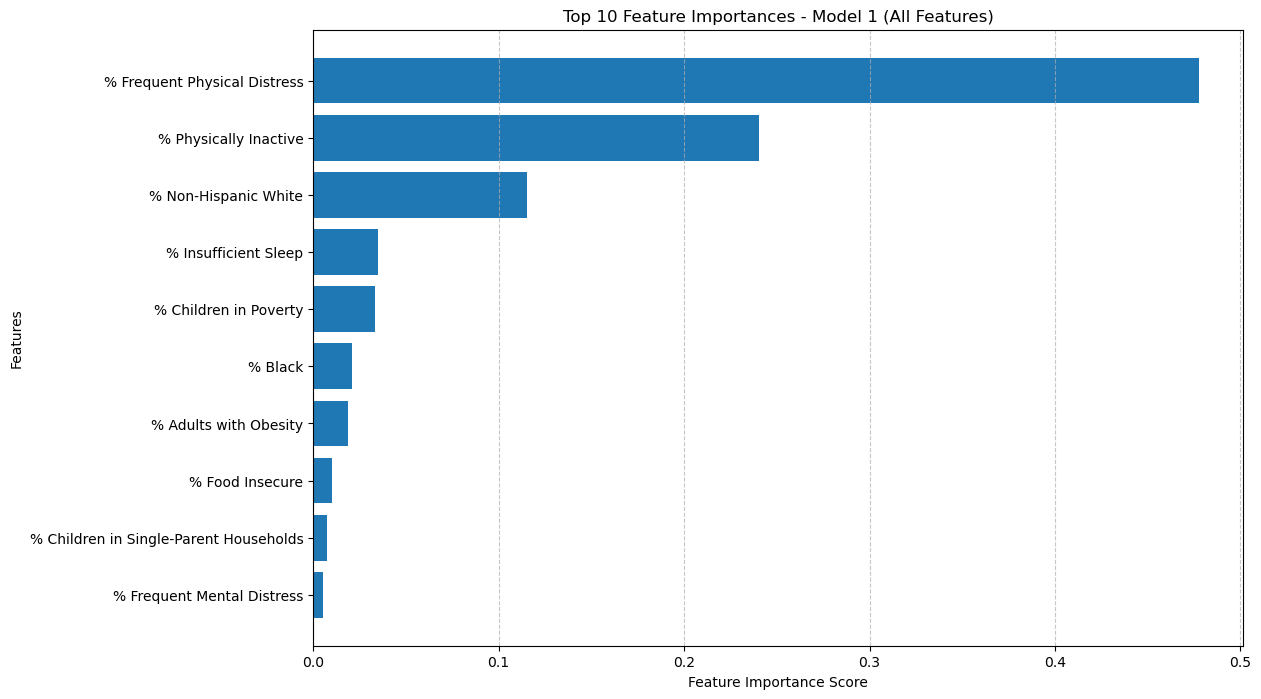

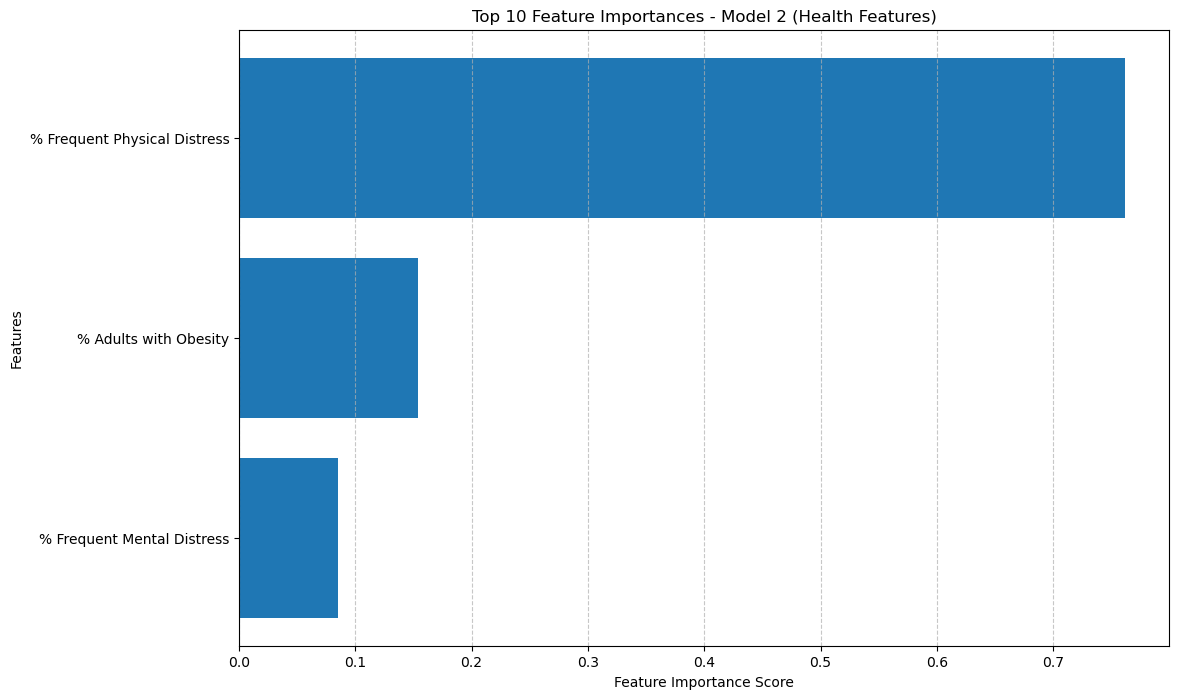

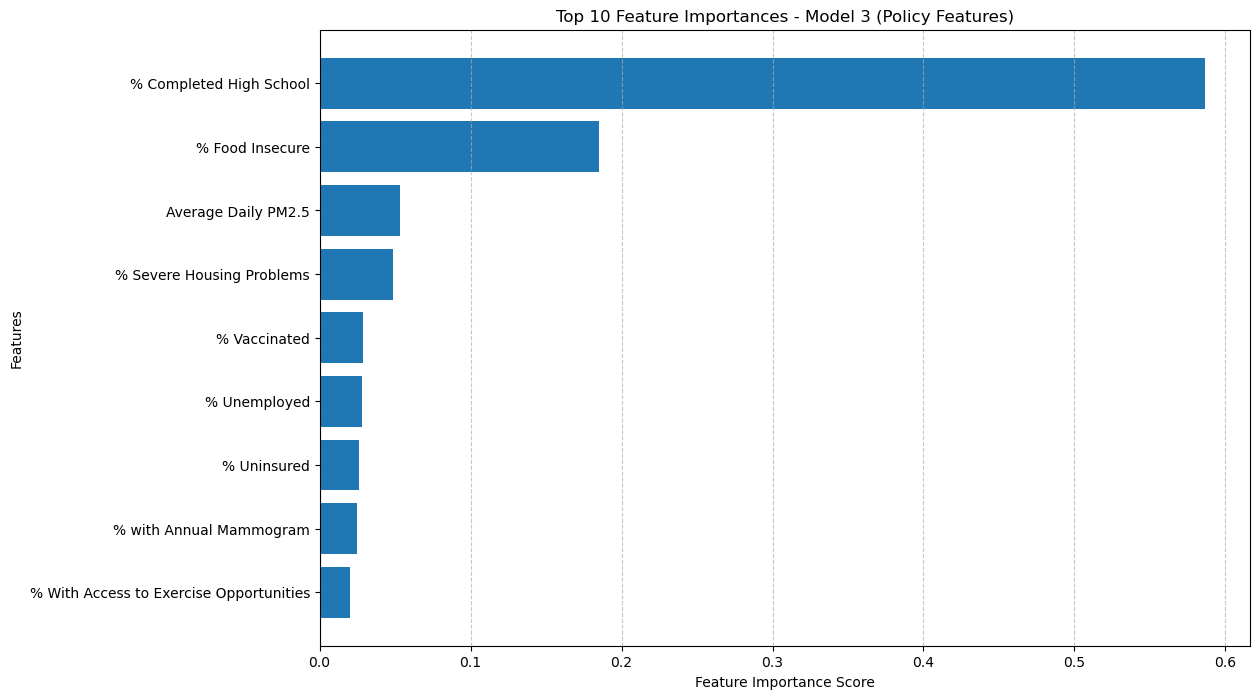

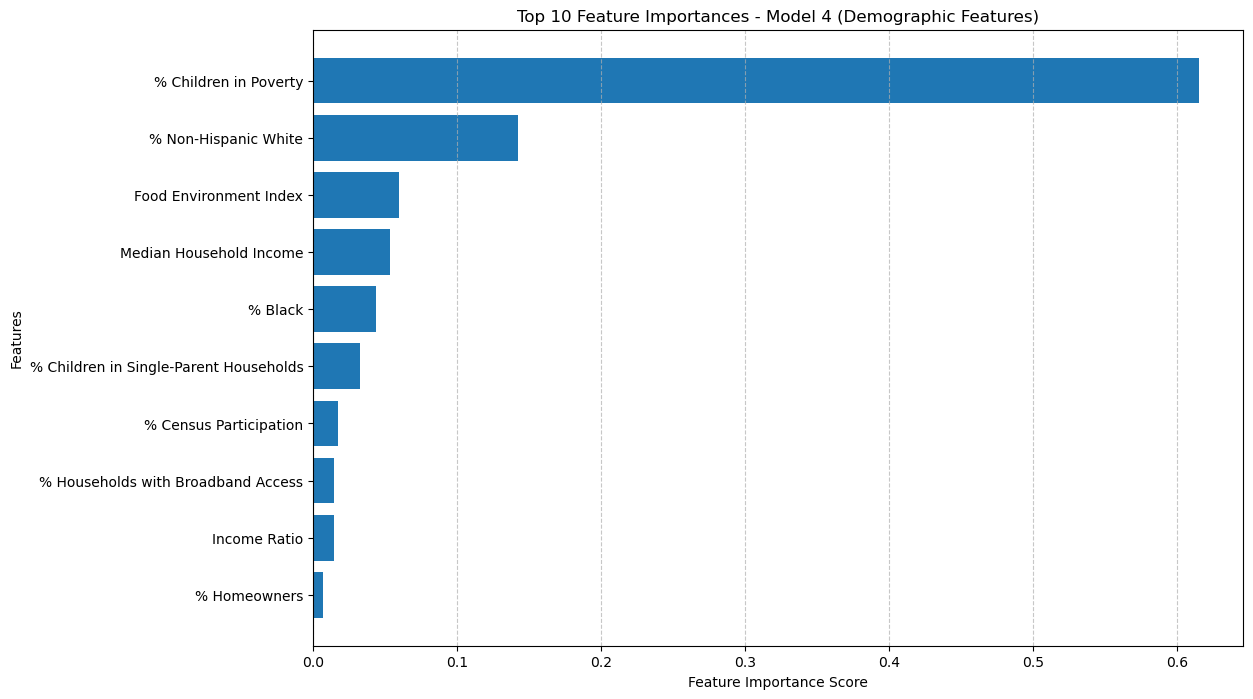

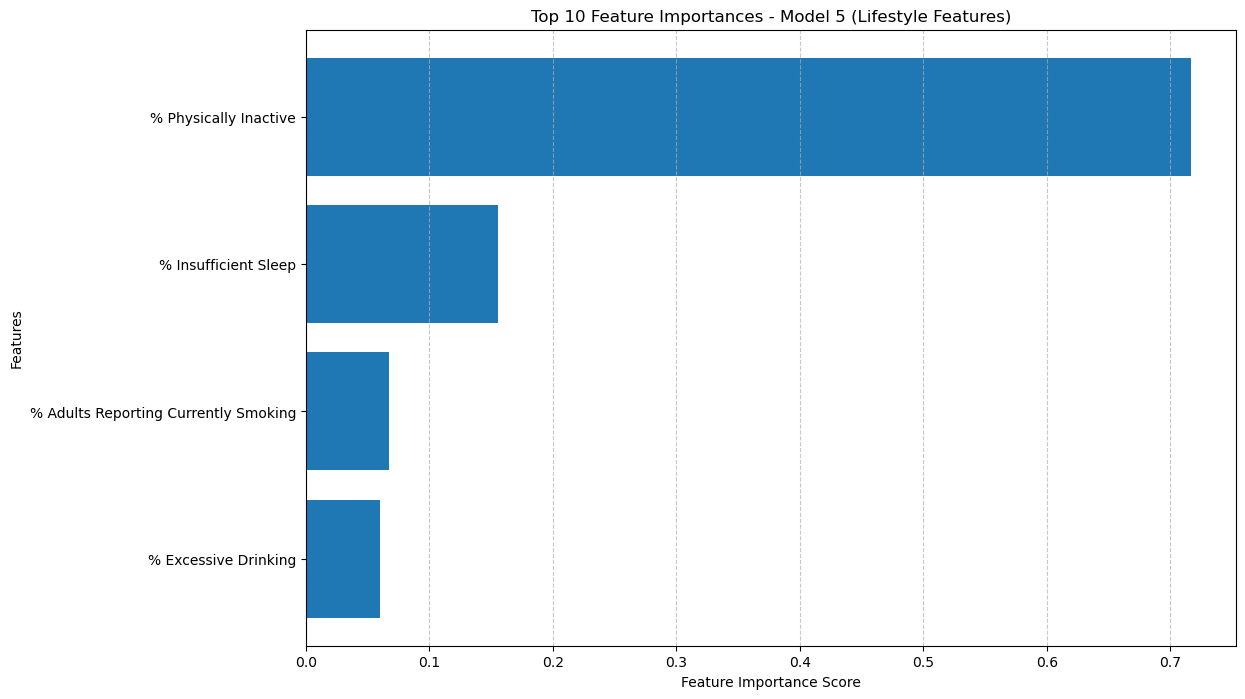

In [12]:
# Plot feature importances for all models
for model_name, model in models.items():
    feature_set = {
        "Model 1 (All Features)": all_features,
        "Model 2 (Health Features)": health_features_filtered,
        "Model 3 (Policy Features)": policy_features_filtered,
        "Model 4 (Demographic Features)": demographic_features_filtered,
        "Model 5 (Lifestyle Features)": lifestyle_features_filtered
    }[model_name]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_set[i] for i in indices]

    plt.figure(figsize=(12, 8))
    plt.barh(sorted_features[:10], importances[indices[:10]], align='center')
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


Residual Analysis and Sample Predictions for Model 1 (All Features):


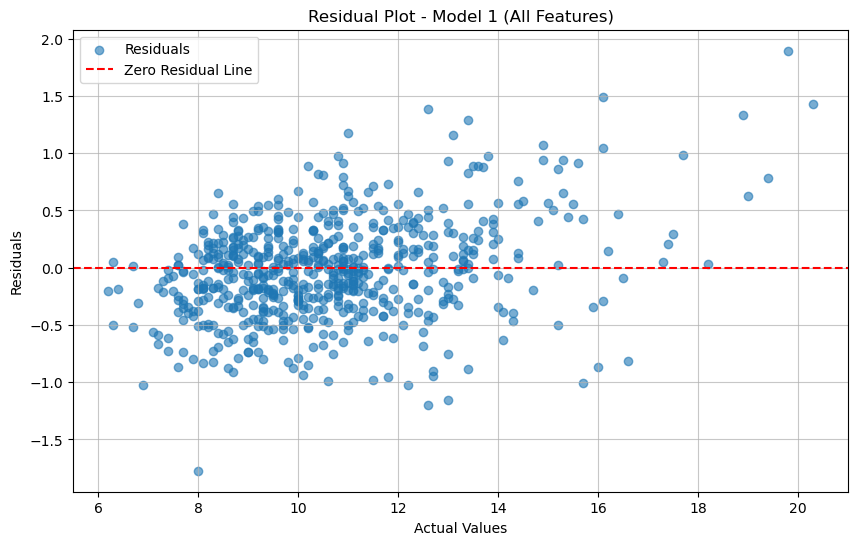

Sample Predictions:
        County         State  % Adults with Diabetes  Predicted  Residual
929   Hodgeman        Kansas                     9.0        9.1      -0.1
2402   Lincoln  South Dakota                     7.4        7.5      -0.1
2652   Kendall         Texas                     8.4        7.7       0.7
2594     Erath         Texas                    10.7       10.6       0.1
598      Boone      Illinois                     9.3        9.8      -0.5


Residual Analysis and Sample Predictions for Model 2 (Health Features):


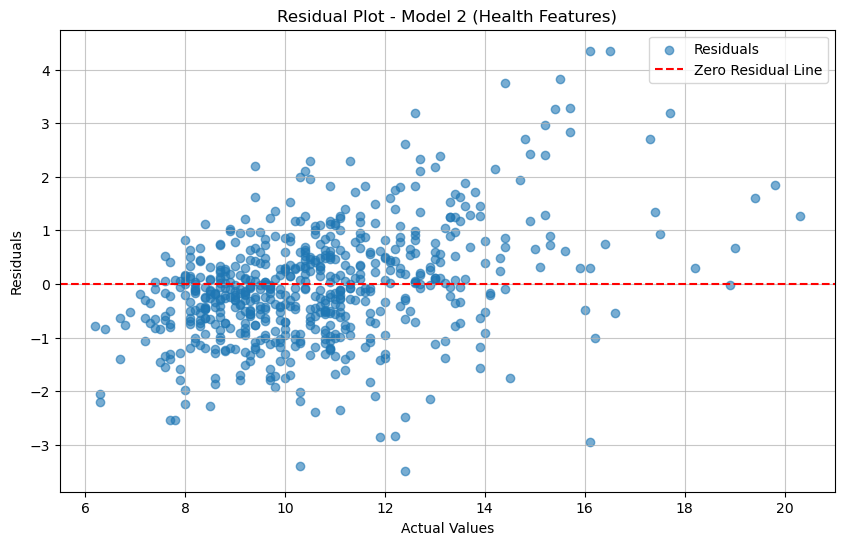

Sample Predictions:
           County         State  % Adults with Diabetes  Predicted  Residual
1313      Wexford      Michigan                     9.1       10.0      -0.9
1187  Piscataquis         Maine                     8.8       10.0      -1.2
2014      McHenry  North Dakota                     8.3        9.0      -0.7
1340     Hennepin     Minnesota                     7.6        7.1       0.5
1860       Oneida      New York                    10.1        9.8       0.3


Residual Analysis and Sample Predictions for Model 3 (Policy Features):


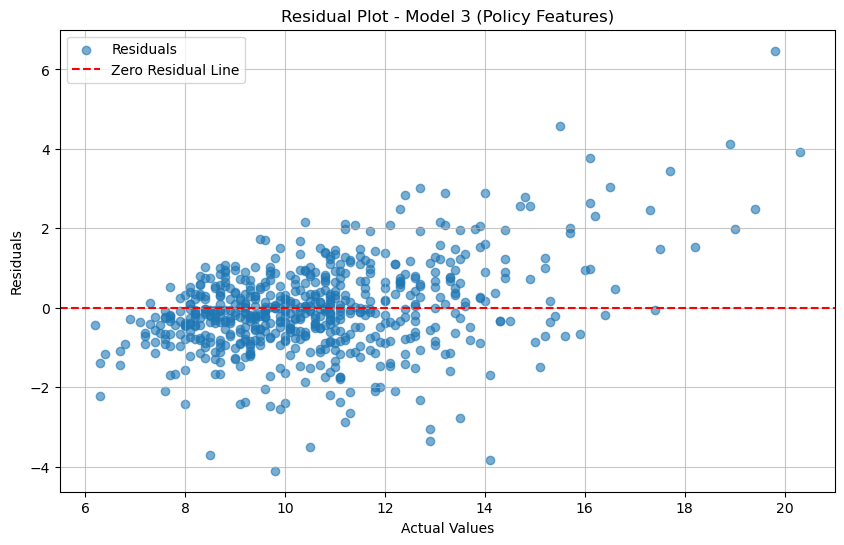

Sample Predictions:
         County       State  % Adults with Diabetes  Predicted  Residual
442      Fannin     Georgia                    10.4       10.5      -0.1
695   Winnebago    Illinois                    10.9       10.9       0.0
1061    Lincoln    Kentucky                    11.7       11.7      -0.0
2989    Whatcom  Washington                     7.9        7.7       0.2
840     Johnson        Iowa                     8.3        8.0       0.3


Residual Analysis and Sample Predictions for Model 4 (Demographic Features):


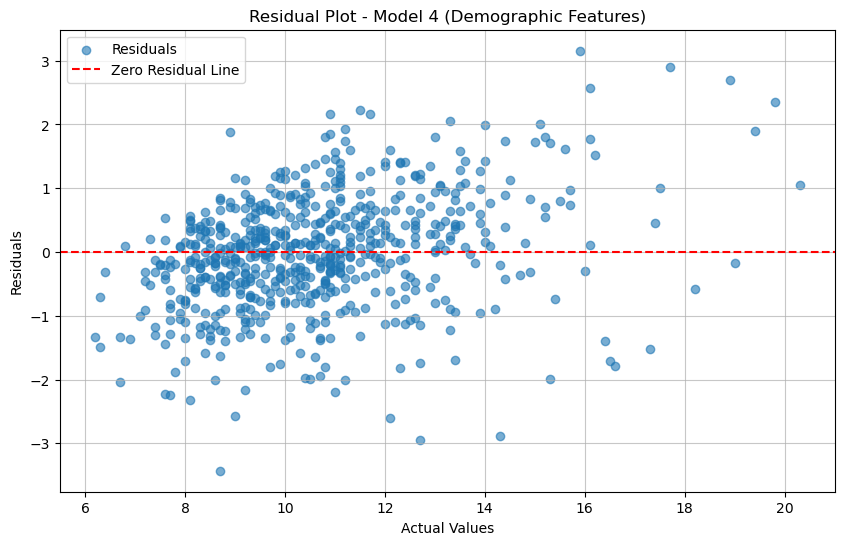

Sample Predictions:
              County           State  % Adults with Diabetes  Predicted  \
1815            Quay      New Mexico                    12.6       13.6   
2883  Northumberland        Virginia                    10.3       11.0   
343         Hamilton         Florida                    13.4       15.1   
1937            Hyde  North Carolina                    12.9       12.6   
144            Izard        Arkansas                    10.8       11.9   

      Residual  
1815      -1.0  
2883      -0.7  
343       -1.7  
1937       0.3  
144       -1.1  


Residual Analysis and Sample Predictions for Model 5 (Lifestyle Features):


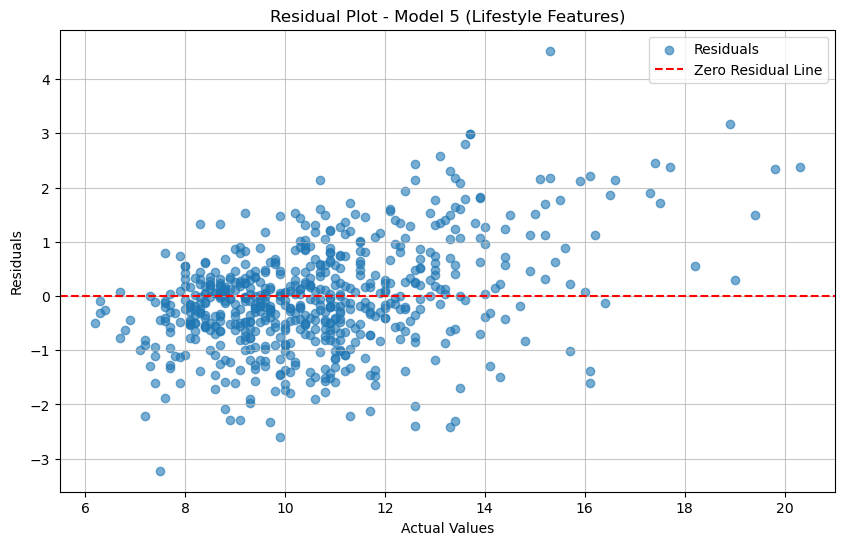

Sample Predictions:
                    County         State  % Adults with Diabetes  Predicted  \
321                Alachua       Florida                    10.5        9.6   
76    Fairbanks North Star        Alaska                     8.0        9.1   
1286               Midland      Michigan                     8.3        8.1   
239                Trinity    California                    10.7        9.1   
2034                 Stark  North Dakota                     8.7        8.7   

      Residual  
321        0.9  
76        -1.1  
1286       0.2  
239        1.6  
2034      -0.0  




In [13]:
import random

# Plot residuals for each model and show sample predictions
for model_name, model in models.items():
    print(f"Residual Analysis and Sample Predictions for {model_name}:")

    # Get feature set and test data
    feature_set = {
        "Model 1 (All Features)": all_features,
        "Model 2 (Health Features)": health_features_filtered,
        "Model 3 (Policy Features)": policy_features_filtered,
        "Model 4 (Demographic Features)": demographic_features_filtered,
        "Model 5 (Lifestyle Features)": lifestyle_features_filtered
    }[model_name]
    
    X_test = test_data[feature_set]
    y_test = test_data[target]

    # Predictions
    y_pred_test = model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred_test

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals, alpha=0.6, label="Residuals")
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residual Plot - {model_name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()

    # Display sample predictions for 5 random counties
    random_indices = random.sample(range(len(test_data)), 5)
    sample_data = test_data.iloc[random_indices]
    sample_predictions = model.predict(sample_data[feature_set])

    # Include County, State, and round numbers
    sample_results = sample_data[["County", "State", target]].copy()  # Include 'County' and 'State' columns
    sample_results["Predicted"] = sample_predictions
    sample_results["Residual"] = sample_results[target] - sample_results["Predicted"]
    sample_results = sample_results.round(1)  # Round all numbers to 1 decimal place
    
    print("Sample Predictions:")
    print(sample_results)
    print("\n" + "="*80 + "\n")
